<img src="https://github.com/seap-udea/xearch/blob/main/resources/xearch-logo.png?raw=true" align="left">

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/xearch/blob/main/public/xsearch-radial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Radial velocity method
## Periodicity and signal folding

In this notebook we will play with radial velocity method. In particular, we will focus on the determination of an exoplanet orbital period.

**Instructions:**
- Start by running all cells.
- Select a planetary system.
- Once selected the planetary system, run again the cell corresponding to the analysis.

In [1]:
#@title Select a planetary system
import sys, os
if 'google.colab' in sys.modules:
  if 'spiceypy' not in sys.modules:
    # Install packages
    !pip install -Uq spiceypy &> /dev/null

  if not os.path.exists('signals.zip'):
    # Get data
    # Available at: https://drive.google.com/file/d/1UucCokiBR6sR8HlVVt6ewBlYX9YoUwbf/view?usp=drive_link
    !gdown -q 1UucCokiBR6sR8HlVVt6ewBlYX9YoUwbf
    !unzip -oq signals.zip

# External modules
import spiceypy as spy
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
import pandas as pd
from ipywidgets import interact, widgets, interactive, fixed, interact_manual, Layout
import glob
import pickle

# Constants
G = c.G.value
Msun = c.M_sun.value
Mearth = c.M_earth.value
Mjup = c.M_jup.value
Rsun = c.R_sun.value
Rearth = c.R_earth.value
Rjup = c.R_jup.value
Mjup2earth = Mjup/Mearth
Rjup2earth = Rjup/Rearth

# Units
K = 1 # Kelvin
days = 86400
JD = days # Julian days
BJD = days # Bessel Julian days
years = 365.25*days # Julian years
au = c.au.value 
deg = np.pi/180
rad = 1/deg
Gyr = 1e9*years
dex = 1

# Routines
def unpickle(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
    return data

class System(object):
    pass

# Read list of planetary systems
planetary_systems = glob.glob('signals/rv/*.pkl')
planetary_systems = sorted([x.split('/')[-1].split('.')[0].replace('_',' ') for x in glob.glob('signals/rv/*.pkl')])

# Read selection of special planetary system
filepath = 'signals/rv/selection.txt'
with open(filepath, 'r') as file:
    lines = file.readlines()
selected_systems = [line.strip().split('.')[0].replace('_',' ') for line in lines]

# Final list of planetary systems
planetary_systems = ['-- selected systems --'] + selected_systems + ['--'] + planetary_systems

In [2]:
from scipy.interpolate import interp1d

cadence = dict(
    frequent = 20,
    medium = 10,
    sparse = 5,
)
error = dict(
    small = 0.05,
    medium = 0.1,
    large = 0.2,
)

# Select planetary system
system = None
def select_planetary_system(
      planetary_system=None,
      sampling_cadence='frequent',
      sampling_error='large',
      number_of_periods=4,
  ):
  global system
  
  # Filepath
  system_filepath = f"signals/rv/{planetary_system.replace(' ','_')}.pkl"
  if os.path.isfile(system_filepath): 
    system = unpickle(f"signals/rv/{planetary_system.replace(' ','_')}.pkl")
  else:
    print(f"No system selected yet")
    return

  # Interpolated radial velocity
  system.tfactor = system.UT/days
  vrad_fun = interp1d(system.tobs,system.vrads,kind='cubic')
  system.tmin = 0.0
  system.tmax = system.T*(number_of_periods)
  system.duration = system.tmax - system.tmin
  # Create time and velocity array
  ts_nominal = np.linspace(system.tmin,system.tmax,number_of_periods*cadence[sampling_cadence])
  vs_nominal = vrad_fun(ts_nominal)
  # Create the signal
  system.ts_signal = ts_nominal 
  # system.dvs_signal = abs(error[sampling_error]*vs_nominal)
  system.dvs_signal = system.Kmax*error[sampling_error]
  system.vrads_signal = np.random.normal(vs_nominal,system.dvs_signal)
  
  # Message
  print(f"Signal with {sampling_cadence} cadence and {sampling_error} errors for {number_of_periods} periods, generated for system '{planetary_system}'.")

In [3]:
select_planetary_system('51 Peg b',sampling_cadence='sparse',sampling_error='medium')

Signal with sparse cadence and medium errors for 4 periods, generated for system '51 Peg b'.


<ErrorbarContainer object of 3 artists>

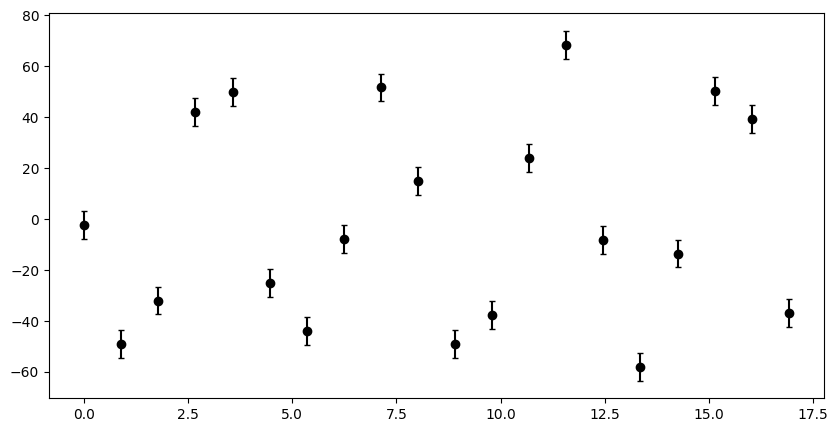

In [4]:
fig,axs = plt.subplots(figsize=(10,5))
ax = axs[0] if isinstance(axs,np.ndarray) else axs
ax.errorbar(system.ts_signal*system.tfactor,system.vrads_signal*system.UV,system.dvs_signal*system.UV,color='k',fmt='o',capsize=2)

In [5]:
planetary_system = interact(
    select_planetary_system,
    planetary_system=widgets.Dropdown(
        options=planetary_systems,
        value=selected_systems[0],
        description='System:',
        disabled=False,
    ),
    sampling_cadence=widgets.Dropdown(
        options=['frequent', 'medium', 'sparse'],
        description='Cadence:',
        disabled=False,
    ),
    sampling_error=widgets.Dropdown(
        options=['small', 'medium', 'large'],
        description='Errors:',
        disabled=False,
    ),
    number_of_periods=widgets.Dropdown(
        options=[2,3,4,5],
        value = 4,
        description='Duration:',
        disabled=False,
    ),    
)

interactive(children=(Dropdown(description='System:', index=1, options=('-- selected systems --', '51 Peg b', …

<ErrorbarContainer object of 3 artists>

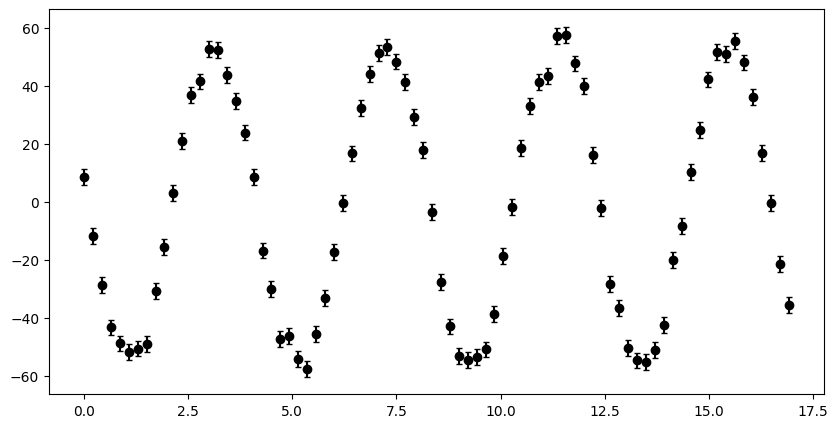

In [6]:
fig,axs = plt.subplots(figsize=(10,5))
ax = axs[0] if isinstance(axs,np.ndarray) else axs
ax.errorbar(system.ts_signal*system.tfactor,system.vrads_signal*system.UV,system.dvs_signal*system.UV,color='k',fmt='o',capsize=2)

Plot data:

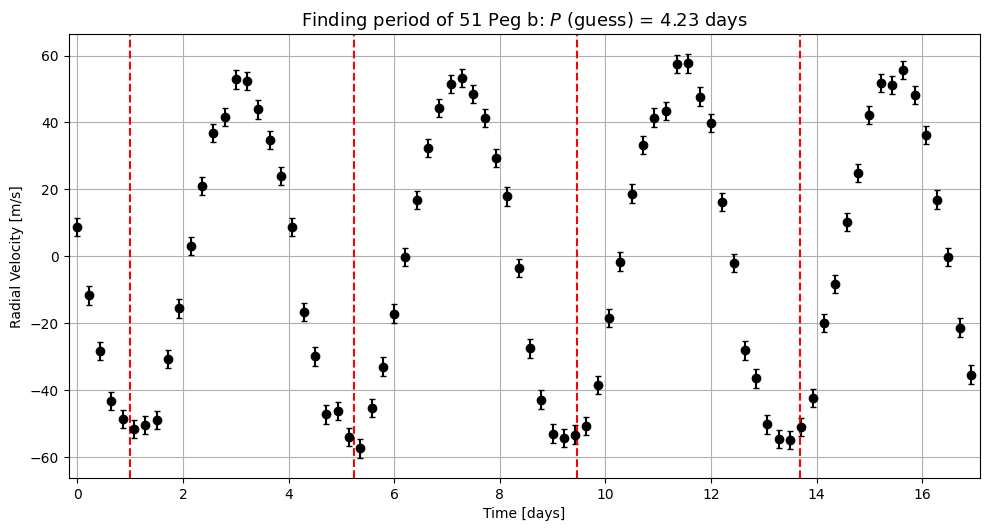

In [14]:
# Arguments
tini=system.tmin*system.tfactor

tini = 1
gperiod = system.T*system.tfactor # system.duration/10
qfolding = 0

# Convert to internal units
tini /= system.tfactor
gperiod /= system.tfactor

# Factor to convert time to days
tfactor = system.UT/days

# Select number of panels
nplots = 2
if qfolding:
    nplots += 1

nplots = 2

# Plot Data
fig,axs = plt.subplots(nplots,1,figsize=(10,5*nplots))
axs = [axs] if not isinstance(axs,np.ndarray) else axs

# Plot signal
ax = axs[0]
ax.errorbar(system.ts_signal*system.UT/days,
            system.vrads_signal*system.UV,
            system.dvs_signal*system.UV,
            color='k',fmt='o',capsize=2)
ax.set_xlabel(f"Time [days]")
ax.set_ylabel(f"Radial Velocity [m/s]")

# Plot periodic lines
tmarks = np.arange(tini,system.tmax,gperiod)
for tm in tmarks:
    ax.axvline(tm*tfactor,ls='--',color='r')

# Decoration
ax.grid()
ax.set_xlim((system.tmin-system.duration/100)*tfactor,
            (system.tmax+system.duration/100)*tfactor)

# Title
ax.set_title(rf"Finding period of {system.data.planet_name}: $P$ (guess) = {gperiod*tfactor:.2f} days",fontsize=13)

# Plot folded 
if qfolding:
    ax = axs[1]

    # Fold signal
    phases = ((system.ts_signal - tini)% gperiod)/gperiod
    
    # Plot folded signal
    ax.errorbar(phases,
                system.vrads_signal*system.UV,
                system.dvs_signal*system.UV,
                color='k',fmt='o',capsize=2)
    ax.set_xlabel(f"Phase")
    ax.set_ylabel(f"Radial Velocity [m/s]")
    ax.set_xlim(-0.01,1.01)
    ax.grid()
else:
    ax = axs[1]
    ax.set_visible(False)


fig.tight_layout()


In [48]:
def plot_signal(
        tini=system.tmin*system.tfactor, # in days
        gperiod=system.T*system.tfactor, # in days
        qfolding=True
    ):
    
    # Convert to internal units
    tini /= system.tfactor
    gperiod /= system.tfactor

    # Plotting options
    errorbar_options = dict(color='k',fmt='o',ms=3,capsize=2)

    # Select number of panels
    nplots = 1
    if qfolding:
        nplots += 1
    nplots = 2

    # Plot Data
    fig,axs = plt.subplots(nplots,1,figsize=(10,4*nplots))
    axs = [axs] if not isinstance(axs,np.ndarray) else axs

    # Plot signal
    ax = axs[0]
    ax.errorbar(system.ts_signal*system.UT/days,
                system.vrads_signal*system.UV,
                system.dvs_signal*system.UV,
                **errorbar_options)
    ax.set_xlabel(f"Time [days]")
    ax.set_ylabel(f"Radial Velocity [m/s]")

    # Plot periodic lines
    tmarks = np.arange(tini,system.tmax,gperiod)
    for tm in tmarks:
        ax.axvline(tm*tfactor,ls='--',color='r')

    # Decoration
    ax.grid()
    ax.set_xlim((system.tmin-system.duration/100)*tfactor,
                (system.tmax+system.duration/100)*tfactor)

    # Title
    ax.set_title(rf"Finding period of {system.data.planet_name}: $P$ (guess) = {gperiod*tfactor:.2f} days",fontsize=13)

    # Plot folded 
    if qfolding:
        ax = axs[1]
        
        # Fold signal
        phases = ((system.ts_signal - tini) % gperiod)/gperiod
        
        # Plot folded signal
        ax.errorbar(phases,
                    system.vrads_signal*system.UV,
                    system.dvs_signal*system.UV,
                    **errorbar_options)
        ax.set_xlabel(f"Phase")
        ax.set_ylabel(f"Radial Velocity [m/s]")
        ax.set_xlim(-0.01,1.01)
        ax.grid()
    else:
        ax = axs[1]
        ax.set_xlabel(f"Phase",color='w')
        ax.set_ylabel(f"Radial Velocity [m/s]",color='w')
        ax.tick_params(axis='x', colors='w')
        ax.tick_params(axis='y', colors='w')
        for spine in ax.spines.values():
            spine.set_visible(False)
        
    #fig.tight_layout()


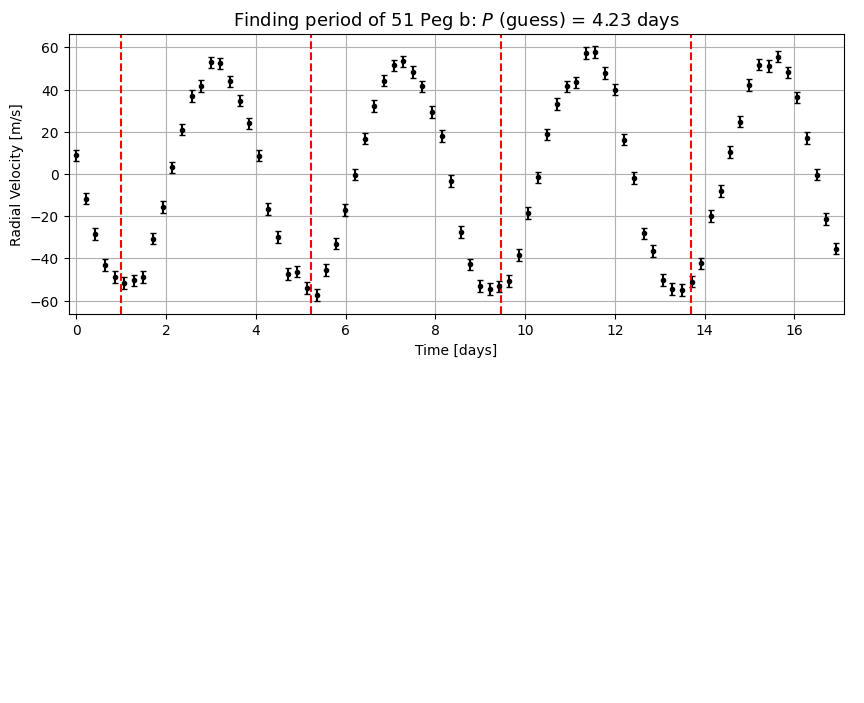

In [49]:
plot_signal(tini=1,qfolding=False)

In [57]:
interact(
    plot_signal,
    tini=widgets.FloatSlider(
        description='Initial time:',
        min=system.tmin*system.tfactor,max=system.tmax*system.tfactor,step=0.001,value=system.tmin*system.tfactor,
        redout_format = '.4f',
        continuous_update=False
    ),
    gperiod=widgets.FloatSlider(
        description='Period: ',
        min=0,max=system.tmax*system.tfactor,step=0.001,value=system.duration*system.tfactor/10,
        continuous_update=False
    ),
    qfolding=widgets.Checkbox(
        description='Fold the signal',value=False,
        continuous_update=False
    ),
    layout=Layout(display='flex', flex_flow='row', justify_content='space-between', align_items='center'),
);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Initial time:', max=16.9232…

In [73]:
step = round(system.duration*system.tfactor/200,1)

interact(
    plot_signal,
    tini=widgets.BoundedFloatText(
        description='Initial time:',
        min=system.tmin*system.tfactor,max=system.tmax*system.tfactor,step=step,value=round(system.tmin*system.tfactor,2),
        redout_format = '.4f',
        continuous_update=False
    ),
    gperiod=widgets.BoundedFloatText(
        description='Period: ',
        min=0,max=system.tmax*system.tfactor,step=step,value=round(system.duration*system.tfactor/10,2),
        redout_format = '.4f',
        continuous_update=False
    ),
    qfolding=widgets.Checkbox(
        description='Fold the signal',value=False,
        continuous_update=False
    ),
    layout=Layout(display='flex', flex_flow='row', justify_content='space-between', align_items='center'),
);

interactive(children=(BoundedFloatText(value=0.0, description='Initial time:', max=16.923200000000005, step=0.…

-----
*Designed and maintained by [Jorge I. Zuluaga](mailto:jorge.zuluaga@udea.edu.co) (2024)*